https://cds-beta.climate.copernicus.eu/training

#0 Mount Google Drive Folder

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!ls

Mounted at /content/gdrive/
gdrive	sample_data


In [2]:
workdir  = "/content/gdrive/My Drive/GECO_RESEARCH/11_R&DGE_SAFER_IDR_12072018_S/SAFERPLACES_Project/corso_geospatial_cescot_2024/lecture_Bagli_Geospatial_2024/"

%cd "$workdir"
!ls



/content/gdrive/My Drive/GECO_RESEARCH/11_R&DGE_SAFER_IDR_12072018_S/SAFERPLACES_Project/corso_geospatial_cescot_2024/lecture_Bagli_Geospatial_2024
'0 (1).1_raster_viz.ipynb'			    '5_applications_GEE (1).ipynb'
 0.1_raster_viz.ipynb				     5_applications_GEE.ipynb
 0.2_rasterio.ipynb				    '6_webapps 2.ipynb'
 0_notebooks.ipynb				     6_webapps.ipynb
 1_C3S_climate-data-store.ipynb			     Bagli_Geospatial_2024.pptx
 21d666330200e61753501e096427fbdf.nc		     C3S_data-tutorial-italiano_2020-11.ipynb
 2a_Planetary_ClimateData.ipynb			    'Create your first book.pdf'
 2_reanalysis-climatology.ipynb			     data
 3_Emilia_Romagna_Flood_2024.ipynb		     img
 4_Hazard_assessment_FLOOD_COASTAL_floodmaps.ipynb   leafmap.ipynb


#Microsoft Planetary
https://planetarycomputer.microsoft.com/

In [3]:
!pip install -U pystac_client
!pip install -U planetary_computer
!pip install zarr
!pip install -U xarray
!pip install adlfs
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=ae48f2ed6b4c6a302ab9f41cdb00e153cd89be9f95096a4ff3cd56a2dae8e3b6
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.6/405.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
def fetch_rain(varname, factor, location, start_date, end_date):
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")
    search_results = catalog.search(
        collections=["era5-pds"], datetime=[start_date, end_date], query={"era5:kind": {"eq": "fc"}}
    )

    items = search_results.items()
    for item in items:
        signed_item = planetary_computer.sign(item)
        asset = signed_item.assets.get(varname)
        if asset:
            dataset = xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
            wind_ds = dataset[varname]
            interval = 0.5
            rounded_coord = round_coordinates(location, interval)
            wind_ds_sliced = wind_ds.sel(lat=rounded_coord[1], lon=rounded_coord[0]) * factor
            df = wind_ds_sliced.to_dataframe().reset_index()
            return df

In [17]:
def round_coordinates(coord, interval):
    rounded_coord = [round(c / interval) * interval for c in coord]
    return rounded_coord

In [40]:

from datetime import datetime, timedelta

import xarray as xr
import pystac_client
import planetary_computer
import pandas as pd
import numpy as np


varnname_Rain="precipitation_amount_1hour_Accumulation"
factor = 1

location = [12.5426646, 44.0684117]

# Assuming the fetch_wind_component function is defined and works correctly

# Define your start and end dates for the entire period you want to fetch
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)

# Initialize an empty DataFrame to hold all the results
all_months_df_rain=[]
all_months_df_rain = pd.DataFrame()

# Loop over each month
current_month_start = start_date
while current_month_start <= end_date:
    # Set the end of the month for the current loop
    next_month_start = (current_month_start.replace(day=1) + timedelta(days=31)).replace(day=1)
    current_month_end = next_month_start - timedelta(days=1)

    # Fetch the wind components for the current month
    df_Rain = fetch_rain(varnname_Rain, 1000, location, current_month_start.isoformat(), current_month_end.isoformat())
    print(df_Rain)

    # Keep only the datetime and wind magnitude fields
    Rain_df = df_Rain[['time', 'precipitation_amount_1hour_Accumulation']]

    # Append the results to the all_months_df DataFrame
    all_months_df_rain = pd.concat([all_months_df_rain, Rain_df])

    # Move to the next month
    current_month_start = next_month_start

# Reset the index of the concatenated DataFrame
all_months_df_rain.reset_index(drop=True, inplace=True)

                   time   lat   lon  precipitation_amount_1hour_Accumulation
0   2019-01-01 00:00:00  44.0  12.5                                 0.000000
1   2019-01-01 01:00:00  44.0  12.5                                 0.000000
2   2019-01-01 02:00:00  44.0  12.5                                 0.000000
3   2019-01-01 03:00:00  44.0  12.5                                 0.000000
4   2019-01-01 04:00:00  44.0  12.5                                 0.000000
..                  ...   ...   ...                                      ...
739 2019-01-31 19:00:00  44.0  12.5                                 0.000000
740 2019-01-31 20:00:00  44.0  12.5                                 0.061035
741 2019-01-31 21:00:00  44.0  12.5                                 0.122070
742 2019-01-31 22:00:00  44.0  12.5                                 0.244141
743 2019-01-31 23:00:00  44.0  12.5                                 0.366211

[744 rows x 4 columns]
                   time   lat   lon  precipitation_a

In [41]:
all_months_df_rain

,time,precipitation_amount_1hour_Accumulation
0,2019-01-01 00:00:00,0.0
1,2019-01-01 01:00:00,0.0
2,2019-01-01 02:00:00,0.0
3,2019-01-01 03:00:00,0.0
4,2019-01-01 04:00:00,0.0
...,...,...
8755,2019-12-31 19:00:00,0.0
8756,2019-12-31 20:00:00,0.0
8757,2019-12-31 21:00:00,0.0
8758,2019-12-31 22:00:00,0.0


In [42]:
import plotly.express as px
import plotly.graph_objects as go

In [43]:
precipitation_data = all_months_df_rain['precipitation_amount_1hour_Accumulation'].sum()


In [44]:
precipitation_data

979.06494

In [45]:
all_months_df_rain

,time,precipitation_amount_1hour_Accumulation
0,2019-01-01 00:00:00,0.0
1,2019-01-01 01:00:00,0.0
2,2019-01-01 02:00:00,0.0
3,2019-01-01 03:00:00,0.0
4,2019-01-01 04:00:00,0.0
...,...,...
8755,2019-12-31 19:00:00,0.0
8756,2019-12-31 20:00:00,0.0
8757,2019-12-31 21:00:00,0.0
8758,2019-12-31 22:00:00,0.0


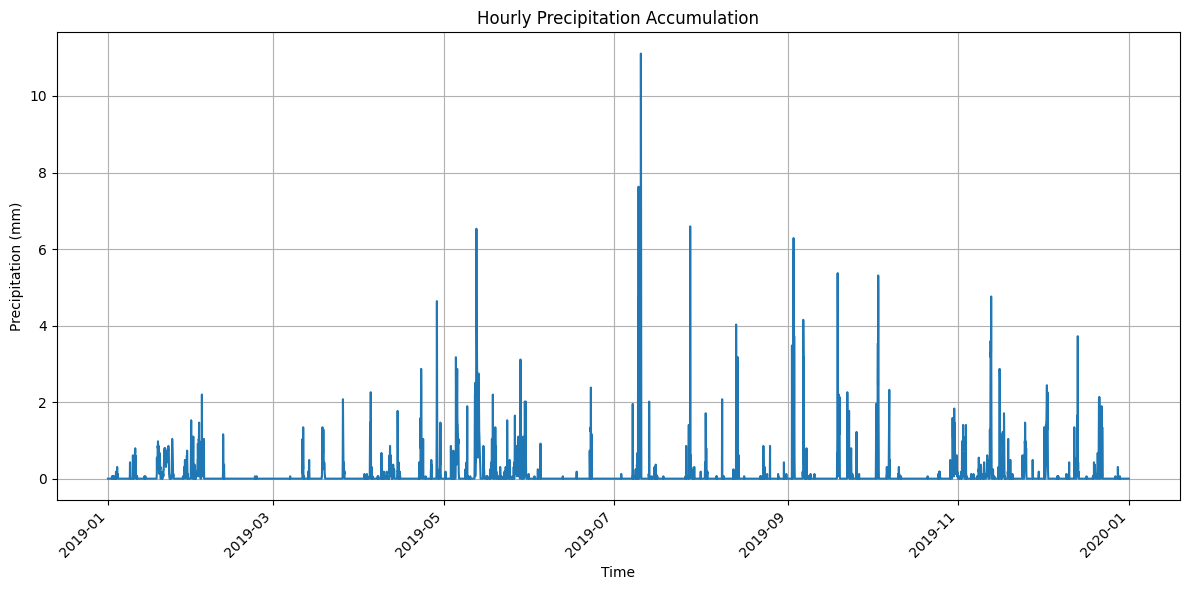

In [46]:
import matplotlib.pyplot as plt

# Assuming all_months_df_rain is populated with data

# Convert 'time' column to datetime objects if it's not already
all_months_df_rain['time'] = pd.to_datetime(all_months_df_rain['time'])

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(all_months_df_rain['time'], all_months_df_rain['precipitation_amount_1hour_Accumulation'])
plt.title('Daily Precipitation Accumulation')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>